## Imports

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import keras
from keras.layers import Conv2D, Input
from keras.models import Model, Sequential
from keras.applications.xception import preprocess_input, decode_predictions
# from keras.models import load_model
from ReadDataCG import train as trainc, test as testc, val as valc
from  ReadDataLocal import train as trainl, test as testl, val as vall

### Getting the data and model

In [12]:
train = trainl
val = vall
test = testl

## Preparing the data

In [62]:
img_size = 150
labels = ['PNEUMONIA', 'NORMAL']

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Make them into arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

X_imgs = np.concatenate((x_test, x_train, x_val))
Y_lab = np.concatenate((y_test, y_train, y_val))

### Making the GradCam Algorithm

In [14]:
# Prepare the model for the gradient cam
def make_model_gradcam_ready(sequential_model, input_shape):
    inp = Input(shape=input_shape)
    x = inp
    for layer in sequential_model.layers:
        config = layer.get_config()
        new_layer = layer.__class__.from_config(config)
        x = new_layer(x)
    new_model = Model(inputs=inp, outputs=x)
    new_model.set_weights(sequential_model.get_weights())
    return new_model

# Loading the model
improved_model = keras.saving.load_model("Models/92_Percent.keras")
Ours = make_model_gradcam_ready(improved_model, input_shape=(150, 150, 1))

# Getting the last convolutional layer of the model. 
last_conv_layer = [layer for layer in Ours.layers if isinstance(layer, Conv2D)][-1]


In [15]:
def make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=None):
    # Ensure model is called so it has a defined input
    _ = model.predict(img_array, verbose=0)

    grad_model = Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Get the gradients of the class output with respect to the conv output
    grads = tape.gradient(class_output, conv_outputs)

    # Take the mean of the gradients over the width and height
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by its corresponding gradient
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)  # add epsilon to avoid divide-by-zero
    return heatmap.numpy()

In [33]:
img_input = np.expand_dims(X_imgs[0], axis=0).astype("float32")
heatmap = make_gradcam_heatmap(img_input, Ours, last_conv_layer)

In [57]:

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    img_rgb = cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_GRAY2BGR)
    return cv2.addWeighted(img_rgb, 1 - alpha, heatmap_colored, alpha, 0)

def show_gradcam_grid(predictions, images, model, last_conv_layer, labels=None, start_index =0, n=6):
    
    end_index = min(start_index + n, len(images))
    plt.figure(figsize=(15, 3 * ((end_index - start_index + 2) // 3)))

    for i in range(n):
        img = images[i]
        img_input = np.expand_dims(img, axis=0).astype("float32")
        heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer)
        overlay = overlay_gradcam(img, heatmap)

        plt.subplot(n // 3 + (n % 3 > 0), 3, i + 1)
        plt.imshow(overlay)
        plt.axis("off")
        title = f" Image {X_imgs[i][1]}"
        if labels is not None:
            title += f" | Given Label: {predictions[labels[i]]}"
        plt.title(title)

    plt.tight_layout()
    plt.show()

Use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts
of the input images contribute most to the model’s predictions
o Choose 5-10 misclassified samples and use Grad-CAM to inspect which regions the
model is focusing on.
o Interpret the results: Ar

In [36]:
predictions = (Ours.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


In [43]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]
Mis_img = X_imgs[incorrect]
C_img = X_imgs[correct]

### Misclassified pictures

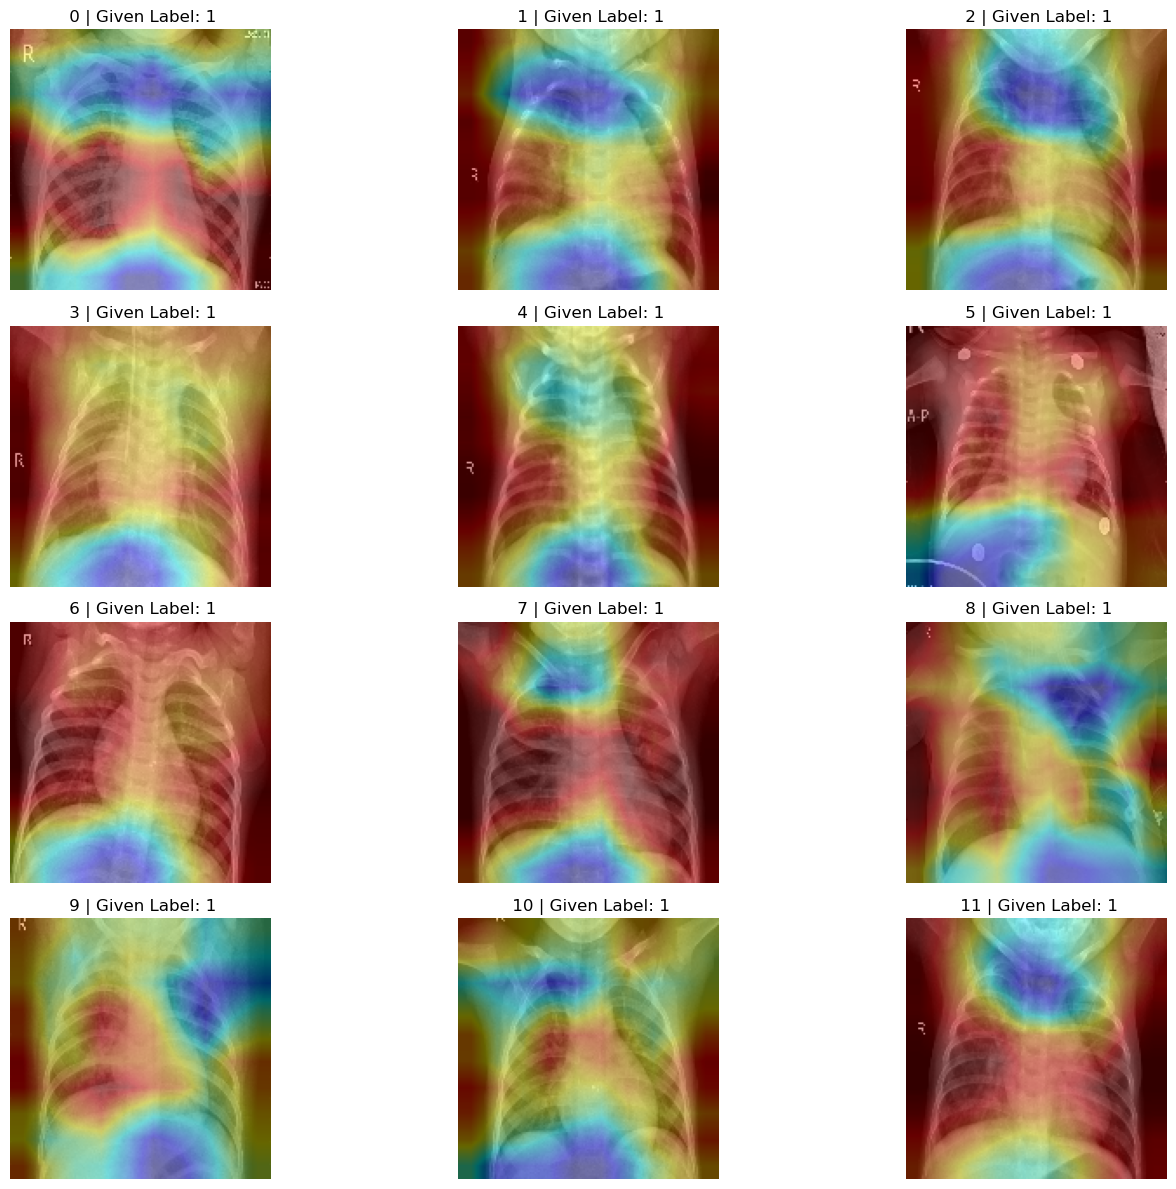

In [60]:
# Next 6
show_gradcam_grid(predictions, Mis_img, Ours, last_conv_layer, labels=incorrect, n=12)

### Correctly Classified

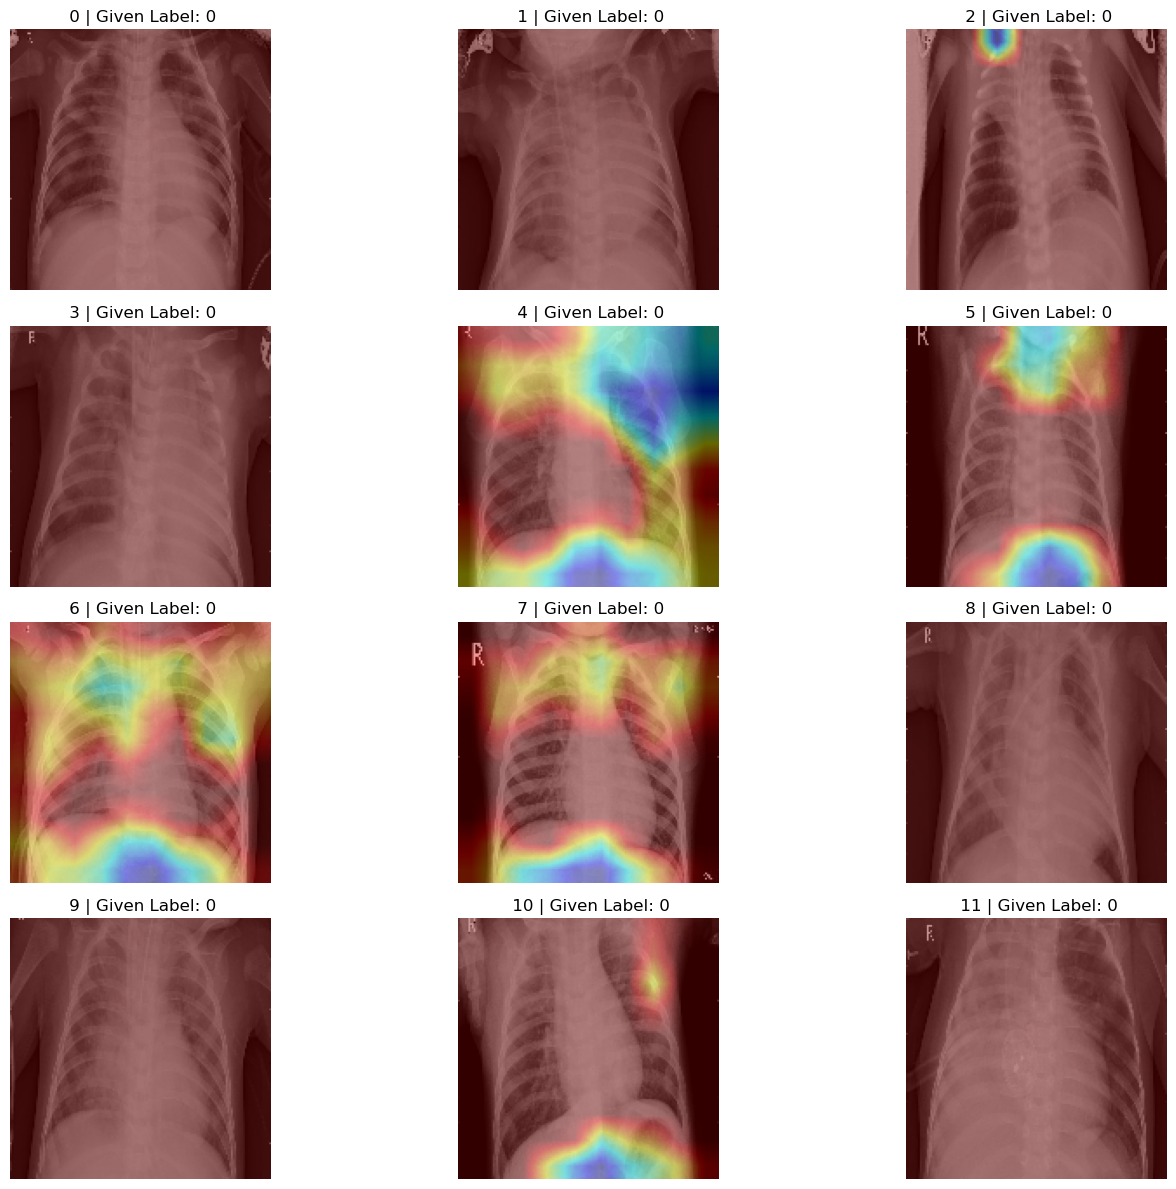

In [61]:
show_gradcam_grid(predictions, C_img, Ours, last_conv_layer, labels=correct, n=12)